In [2]:
import io
import os

from collections import defaultdict
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, MaxPool2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.utils import get_custom_objects
from keras.layers import Activation

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))

# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Mish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'


def mysoftplus(x):

    mask_min = tf.cast((x<-20.0),tf.float32)
    ymin = mask_min*tf.math.exp(x)

    mask_max = tf.cast((x>20.0),tf.float32)
    ymax = mask_max*x
    
    mask= tf.cast((abs(x)<=20.0),tf.float32)
    y = mask*tf.math.log(tf.math.exp(x) + 1.0)
    
    return(ymin+ymax+y)    
        


def mish(x):
    return (x* tf.math.tanh(mysoftplus(x)))
    
   
    

get_custom_objects().update({'mish': Mish(mish)})

def _conv_block(inp, convs, skip=False):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)), name='zerop_' + str(conv['layer_idx']))(x)  # peculiar padding as darknet prefer left and top
        
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='convn_' + str(conv['layer_idx']) if conv['bnorm'] else 'conv_' + str(conv['layer_idx']),
                   activation='mish' if conv['activ'] == 2 else None,
                   use_bias=True)(x)
                  
        if conv['activ'] == 1: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
            
    return add([skip_connection, x],  name='add_' + str(conv['layer_idx']+1)) if skip else x

def make_yolov4_model():
        
    input_image = Input(shape=(608, 608, 3), name='input_0')

    # Layer  0
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 0}])
    layer_0 = x
    # Layer  1
    x = _conv_block(x, [{'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 1}])
    layer_1 = x
    
    # Layer  2 
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 2}])
    layer_2 = x
    
    # route  1 (layers = -2)
    x = layer_1
    # Layer  3 => 5
    x = _conv_block(x, [{'filter': 64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 4},
                        {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 5},
                        {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 6}],
                   skip = True)

    # Layer  8 => 8
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 8}])
    layer_8 = x
    
    # route  8+2 (layers = -1, -7)
    x = concatenate([layer_8, layer_2], name='concat_9')
    
    # Layer 10 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 10},
                        {'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 11}])
    layer_11 = x
    
    # Layer  12
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 12}])
    layer_12 = x
    
    # route  11 (layers = -2)
    x = layer_11
    # Layer 14 => 16
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 14},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 15},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 16}],
                   skip = True)
    
    # Layer 18 => 19
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 18},
                        {'filter':  64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 19}],
                   skip = True)
    
    # Layer  21
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 21}]) 
    layer_21 = x
    
    # route  21+12 (layers = -1,-10)
    x = concatenate([layer_21, layer_12], name='concat_22')
    
    # Layer 23 => 24
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 23},
                        {'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 24}])
    layer_24 = x
    
    # Layer  25
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 25}])
    layer_25 = x
    
    # route  24 (layers = -2)
    x = layer_24
    
    # Layer 27 => 29
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 27},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 28},
                        {'filter':  128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 29}],
                   skip = True)
    
    # Layer 31 => 50
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 31+(i*3)},
                            {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 32+(i*3)}],
                       skip = True)
  
    # Layer  52
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 52}])
    layer_52 = x
        
    # route  52+25 (layers = -1,-28)
    x = concatenate([layer_52, layer_25],  name='concat_53')
    
    # Layer 54
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 54}])
    layer_54 = x
    
    # Layer  55
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 55}])
    layer_55 = x
    
    # Layer  56
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 56}])
    layer_56 = x
    
    # route  55 (layers = -2)
    x = layer_55
    
    # Layer 58 => 60
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 58},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 59},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 60}],
                   skip = True)     

    # Layer 62 => 81
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 62+(i*3)},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 63+(i*3)}],
                       skip = True)

    # Layer  83
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 83}])
    layer_83 = x

    # route  83+56 (layers = -1,-28)
    x = concatenate([layer_83, layer_56], name='concat_84')
    
    # Layer 85
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 85}])
    layer_85 = x
    
    # Layer  86
    x = _conv_block(x, [{'filter':  1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 2, 'layer_idx': 86}])
    layer_86 = x
    
    # Layer  87
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 87}])
    layer_87 = x
        
    # route  86 (layers = -2)
    x = layer_86
    
    # Layer 89 => 92
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 89},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 90},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 91}],
                   skip = True) 
    
    
    # Layer 93 => 100
    for i in range(3):
        x = _conv_block(x, [{'filter': 512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 93+(i*3)},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 94+(i*3)}],
                       skip = True)  
    
    
    # Layer  102 => 102
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 102}])  
    layer_102 = x
    
    # route  102+87 (layers = -1,-16)
    x = concatenate([layer_102, layer_87], name='concat_103')
    
    # Layer 104 => 107
    x = _conv_block(x, [{'filter':  1024, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 2, 'layer_idx': 104},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 105},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 106},                        
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 107}])
    
    #-- begin SPP part (Spatial Pyramid Pooling layer)
    layer_107 = x
    
    # Layer 108
    x =MaxPool2D(pool_size=(5, 5), strides=1, padding='same', name = 'layer_108')(x)  
    layer_108 = x
    
    # route  107 (layers = -2)
    x = layer_107
    
    # Layer 110
    x =MaxPool2D(pool_size=(9, 9), strides=1, padding='same', name = 'layer_110')(x)    
    layer_110 = x
    
    # route  107 (layers = -4)
    x = layer_107
        
    # Layer 112
    x =MaxPool2D(pool_size=(13, 13), strides=1, padding='same', name = 'layer_112')(x) 
    layer_112 = x
    
    # route  112+110+108+107 (layers=-1,-3,-5,-6)
    x = concatenate([layer_112, layer_110, layer_108, layer_107], name='concat_113')
    #-- end SPP part
    
    layer_113 = x
    
    # Layer 114 => 116
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 114},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 115},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 116}])
    layer_116 = x
                        
    # Layer 117                    
    x = _conv_block(x, [{'filter':   256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 117}])
    layer_117 = x
    # Layer 118
    x = UpSampling2D(size=(2, 2), name = 'upsamp_118')(x)
    layer_118 = x
                        
    # route  85 (layers = 85)
    x = layer_85
    
    # Layer 120
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 120}])
    layer_120 = x
                        
    # route  120+118 (layers = -1, -3)
    x = concatenate([layer_120, layer_118],  name='concat_121')
    layer_121 = x                    
    # Layer 122 => 126
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 122},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 123},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 124},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 125},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 126}])
    layer_126 = x 
                        
    # Layer 127                    
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 127}])
    layer_127 = x
    # Layer 128
    x = UpSampling2D(size=(2, 2), name = 'upsamp_128')(x)
    layer_128 = x
                        
    # route  54 (layers = 54)
    x = layer_54
    
    # Layer 130
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ': 1, 'layer_idx': 130}])
    layer_130 = x
                        
    # route  130+128 (layers = -1, -3)                 
    x = concatenate([layer_130, layer_128],  name='concat_131')
    layer_131 = x                    
    # Layer 132 => 136
    x = _conv_block(x, [{'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 132},
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 133},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 134},  
                        {'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 135},
                        {'filter':  128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 136}])
    layer_136 = x                   
    
    # Layer 137 => 138
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 137}]) 
    layer_137 = x 
    x = _conv_block(x, [{'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 138}])   
  
    # Layer 139
    yolo_139 = x
                        
    # route  136 (layers = -4)
    x = layer_136
    
    # Layer 141
    x = _conv_block(x, [{'filter':  256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 141}])
    layer_141 = x
                        
    # route  141+126 (layers = -1, -16)                   
    x = concatenate([layer_141, layer_126],  name='concat_142')
    
    # Layer 143 => 147
    x = _conv_block(x, [{'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 143},
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 144},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 145},  
                        {'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 146},
                        {'filter':  256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':   1, 'layer_idx': 147}])  
    layer_147 = x
                        
    # Layer 148 => 149                    
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':  1, 'layer_idx': 148},
                        {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':  0, 'layer_idx': 149}])
                        
    # Layer 150
    yolo_150 = x                  
    
    # route  147 (layers = -4)
    x = layer_147
        
    # Layer 152
    x = _conv_block(x, [{'filter':  512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'activ': 1, 'layer_idx': 152}])
    layer_152 = x  
                        
    # route  152+166 (layers = -1, -37)                   
    x = concatenate([layer_152, layer_116],  name='concat_153') 
                        
                        
    # Layer 154 => 160
    x = _conv_block(x, [{'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 154},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 155},
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 156},
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 157},  
                        {'filter':   512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 158},   
                        {'filter':  1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'activ':    1, 'layer_idx': 159},
                        {'filter':   255, 'kernel': 1, 'stride': 1, 'bnorm': True, 'activ':    0, 'layer_idx': 160}])  
                     
                        
    # Layer 161
    yolo_161 = x
                        
                        
    model = Model(input_image, [yolo_139, yolo_150, yolo_161], name = 'Yolo_v4')    
    return model

Using TensorFlow backend.


TensorFlow version: 2.1.0
Eager execution: True
Keras version: 2.2.4-tf


In [3]:
# Define the model
model = make_yolov4_model()

In [4]:
model.summary()

Model: "Yolo_v4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
convn_0 (Conv2D)                (None, 608, 608, 32) 896         input_0[0][0]                    
__________________________________________________________________________________________________
zerop_1 (ZeroPadding2D)         (None, 609, 609, 32) 0           convn_0[0][0]                    
__________________________________________________________________________________________________
convn_1 (Conv2D)                (None, 304, 304, 64) 18496       zerop_1[0][0]                    
____________________________________________________________________________________________

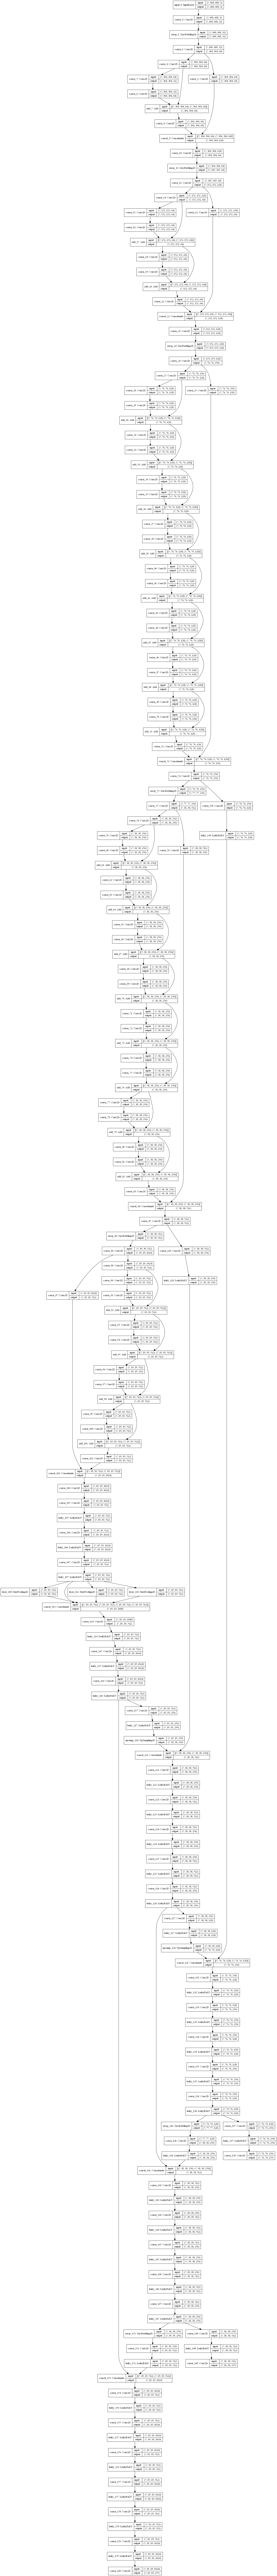

In [5]:
tf.keras.utils.plot_model( model, show_shapes=True)

In [6]:
from keras.models import Model
import struct

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                print("reading 64 bytes")
                w_f.read(8)
            else:
                print("reading 32 bytes")
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        count = 0
        ncount = 0
        for i in range(161):
            try:

                conv_layer = model.get_layer('convn_' + str(i))
                filter = conv_layer.kernel.shape[-1]
                nweights = np.prod(conv_layer.kernel.shape) # kernel*kernel*c*filter
                
                print("loading weights of convolution #" + str(i)+ "- nb parameters: "+str(nweights+filter))             
                
                if i  in [138, 149, 160]:
                    print("Special processing for layer "+ str(i))
                    bias  = self.read_bytes(filter) # bias
                    weights = self.read_bytes(nweights) # weights
                
                else:                    
                    bias  = self.read_bytes(filter) # bias
                    scale = self.read_bytes(filter) # scale
                    mean  = self.read_bytes(filter) # mean
                    var   = self.read_bytes(filter) # variance
                    weights = self.read_bytes(nweights) # weights
                    
                    bias = bias - scale  * mean / (np.sqrt(var + 0.00001)) #normalize bias

                    weights = np.reshape(weights,(filter,int(nweights/filter)))  #normalize weights
                    A = scale / (np.sqrt(var + 0.00001))
                    A= np.expand_dims(A,axis=0)
                    weights = weights* A.T
                    weights = np.reshape(weights,(nweights))
                

                weights = weights.reshape(list(reversed(conv_layer.get_weights()[0].shape)))                 
                weights = weights.transpose([2,3,1,0])
                
                if len(conv_layer.get_weights()) > 1:
                    a=conv_layer.set_weights([weights, bias])
                else:    
                    a=conv_layer.set_weights([weights])
                
                count = count+1
                ncount = ncount+nweights+filter
             
            except ValueError:
                print("no convolution #" + str(i)) 
        
        print(count, "Conv normalized layers loaded ", ncount, " parameters")
    
    def reset(self):
        self.offset = 0


In [7]:
# Get and compute the weights
weight_reader = WeightReader('models/yolo/yolov4.weights')
weight_reader.load_weights(model)


reading 64 bytes
loading weights of convolution #0- nb parameters: 896
loading weights of convolution #1- nb parameters: 18496
loading weights of convolution #2- nb parameters: 4160
no convolution #3
loading weights of convolution #4- nb parameters: 4160
loading weights of convolution #5- nb parameters: 2080
loading weights of convolution #6- nb parameters: 18496
no convolution #7
loading weights of convolution #8- nb parameters: 4160
no convolution #9
loading weights of convolution #10- nb parameters: 8256
loading weights of convolution #11- nb parameters: 73856
loading weights of convolution #12- nb parameters: 8256
no convolution #13
loading weights of convolution #14- nb parameters: 8256
loading weights of convolution #15- nb parameters: 4160
loading weights of convolution #16- nb parameters: 36928
no convolution #17
loading weights of convolution #18- nb parameters: 4160
loading weights of convolution #19- nb parameters: 36928
no convolution #20
loading weights of convolution #21-

In [8]:
# Save the model
! rm models\yolo\yolov4.h5

model.save('models/yolo/yolov4.h5')
! dir models\yolo\*.h5

 Le volume dans le lecteur C s'appelle Windows
 Le num‚ro de s‚rie du volume est CCDC-AB26

 R‚pertoire de C:\Users\edh\deep learning\models\yolo

14/05/2020  21:44       248ÿ676ÿ368 yolov3.h5
02/06/2020  12:26       257ÿ812ÿ724 yolov4.h5
               2 fichier(s)      506ÿ489ÿ092 octets
               0 R‚p(s)  250ÿ636ÿ214ÿ272 octets libres


In [9]:
# Load the model
from keras.models import load_model, Model
yolo_model = load_model("models/yolo/yolov4.h5")

C:\Users\edh\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [11]:
# Load the labels
labels = read_labels("models/yolo/coco_classes.txt")
print(labels)
print("nb labels: ",len(labels))

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
nb labels:  80


In [12]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, interpolation = 'bilinear', target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    
    return image, width, height

In [13]:
# Pre-process the image
input_w, input_h = 608, 608
photo_filename = 'images/chat1.jpg'
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)
print("input image",image.shape)

image initial size:  1500 1000
input image (1, 608, 608, 3)


In [14]:
# Run the model
yhat = yolo_model.predict(image)

print("output",[a.shape for a in yhat])


output [(1, 76, 76, 255), (1, 38, 38, 255), (1, 19, 19, 255)]


In [15]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w, anchors_nb, scales_x_y):
    grid_h, grid_w = netout.shape[:2]  
    nb_box = anchors_nb
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5 # 5 = bx,by,bh,bw,pc

    print("grid_h,grid_w: ",grid_h,grid_w)   
    print("nb class: ",nb_class)   
    
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2]) # x, y
    netout[..., :2] = netout[..., :2]*scales_x_y - 0.5*(scales_x_y - 1.0) # scale x, y

    netout[..., 4:] = _sigmoid(netout[..., 4:]) # objectness + classes probabilities

    for i in range(grid_h*grid_w):

        row = i / grid_w
        col = i % grid_w
        
        
        for b in range(nb_box):
            # 4th element is objectness
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness > obj_thresh):
                print("objectness: ",objectness)                
            
                # first 4 elements are x, y, w, and h
                x, y, w, h = netout[int(row)][int(col)][b][:4]
                x = (col + x) / grid_w # center position, unit: image width
                y = (row + y) / grid_h # center position, unit: image height
                w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
                h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height            
            
                # last elements are class probabilities
                classes = objectness*netout[int(row)][col][b][5:]
                classes *= classes > obj_thresh
                box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)           
                boxes.append(box)
    return boxes


In [16]:
# Compute the Yolo layers
obj_thresh = 0.25
anchors = [ [12, 16, 19, 36, 40, 28],[36, 75, 76, 55, 72, 146],[142, 110, 192, 243, 459, 401]]
scales_x_y = [1.2, 1.1, 1.05]
boxes = list()

for i in range(len(anchors)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], obj_thresh, input_h, input_w, len(anchors), scales_x_y[i])

print("nb boxes detected; ",len(boxes))

grid_h,grid_w:  76 76
nb class:  80
grid_h,grid_w:  38 38
nb class:  80
grid_h,grid_w:  19 19
nb class:  80
objectness:  0.64596844
objectness:  0.4730491
objectness:  0.8990112
objectness:  0.96898
objectness:  0.5205534
objectness:  0.62212545
nb boxes detected;  6


In [17]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
 new_w, new_h = net_w, net_h
 for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [18]:
# Correct the boxes according the inital size of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

In [19]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [20]:
# Suppress the non Maximal boxes
do_nms(boxes, 0.5)
print("nb boxes remaining; ",len(boxes))

nb boxes remaining;  6


In [21]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh, colors):
    v_boxes, v_labels, v_scores, v_colors = list(), list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):

            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                v_colors.append(colors[i])
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores, v_colors

In [22]:
# Get the details of the detected objects for a threshold > 0.6
class_threshold = 0.6
colors = generate_colors(labels)
v_boxes, v_labels, v_scores, v_colors = get_boxes(boxes, labels, class_threshold, colors)
print("nb boxes remaining; ",len(v_boxes))

nb boxes remaining;  1


In [23]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores, v_colors):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color=v_colors[i])
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

cat 96.746164560318 487 1488 107 1026


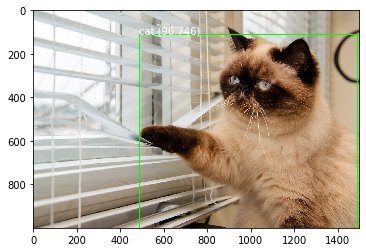

In [24]:
# Draw the result
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i],  v_boxes[i].xmin, v_boxes[i].xmax, v_boxes[i].ymin, v_boxes[i].ymax)
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores, v_colors)